In [ ]:
import tensorflow as tf
import numpy as np
import tqdm
import glob
import os
import shutil

In [ ]:
import librosa
import keras
from keras.layers import Conv2D,MaxPool2D,BatchNormalization,Input,Activation,MaxPool1D,Conv1D
from keras.layers import CuDNNGRU as GRU
from keras.layers import CuDNNLSTM as LSTM
from keras.layers import Reshape, Bidirectional,Flatten,Dense,InputLayer,Permute,Multiply

In [3]:
data_root = "/home/philip/data/Keyword_spot/"

In [4]:
class_indices = {
'bed': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'down': 4, 'eight': 5, 'five': 6, 'four': 7, 'go': 8, 'happy': 9, 'house': 10, 'left': 11,
 'marvin': 12, 'nine': 13, 'no': 14, 'off': 15, 'on': 16, 'one': 17, 'right': 18, 'seven': 19, 'sheila': 20, 'six': 21, 'stop': 22,
 'three': 23, 'tree': 24, 'two': 25, 'up': 26, 'wow': 27, 'yes': 28, 'zero': 29}

In [5]:
class_num=len(class_indices)

In [6]:
from keras import backend as K

K.set_learning_phase(1)

In [7]:
all_class_file = glob.glob(data_root+"train/audio/***/*.wav")
all_silence_file = glob.glob(data_root+"train/silence/*.wav")+glob.glob(data_root+"train/silence_bg/*.wav")

In [8]:
def get_seq_from_filename(filename):
    try:
        y,sr = librosa.load(filename,sr=16000)
    except:
        print(filename)
    if len(y)<16000:
        pad_with = (16000-len(y))//2+1
        y = np.pad(y,pad_with,'constant')[:16000]
    return y

In [9]:
def get_label_from_filename(full_filename):
    dirname = os.path.dirname(full_filename)
    label = dirname.split("/")[-1]
    label_indice = class_indices[label]
    one_hot_encode = keras.utils.to_categorical(label_indice,len(class_indices))
    return one_hot_encode

In [10]:
class_label = np.squeeze(np.array([get_label_from_filename(_) for _ in all_class_file],np.float32))
all_class_file = np.array(all_class_file)
non_silence_label = np.ones_like(all_class_file,np.float32)
non_silence_label = np.expand_dims(non_silence_label,1)
silence_label_cls = np.zeros((len(all_silence_file),class_num),np.float32)
all_silence_file = np.array(all_silence_file)
silence_label_bin = np.zeros_like(all_silence_file,np.float32)
silence_label_bin = np.expand_dims(silence_label_bin,1)

In [11]:
# all_class_file = np.array(list(map(get_seq_from_filename,all_class_file)),np.float32)
# all_silence_file = np.array(list(map(get_seq_from_filename,all_silence_file)),np.float32)

In [12]:
# binary_class_dataset_audio = tf.data.Dataset.from_tensor_slices(all_training_file)
# binary_class_dataset_silence = tf.data.Dataset.from_tensor_slices(all_silence_file)

In [13]:
class_data_set = tf.data.Dataset.from_tensor_slices((all_class_file,class_label, non_silence_label))
silence_data_set = tf.data.Dataset.from_tensor_slices((all_silence_file,silence_label_cls,silence_label_bin))

In [14]:
def get_sequence_from_file(filename,class_label,binary_label):
    data = tf.read_file(filename)
    audio_seq = tf.contrib.ffmpeg.decode_audio(data,file_format='wav',samples_per_second=16000,channel_count=1)
    pad = tf.concat([audio_seq, tf.zeros((16000,1))],0)[:16000] 
    return pad,class_label,binary_label

In [15]:
batch_size = 128
class_batch_size = int(batch_size*0.75)
silence_batch_size = int(batch_size*0.25)

In [16]:
class_data_set = class_data_set.map(get_sequence_from_file,num_parallel_calls=6)
silence_data_set = silence_data_set.map(get_sequence_from_file,num_parallel_calls=6)
class_data_set = class_data_set.shuffle(buffer_size=6400).batch(class_batch_size).repeat()
silence_data_set = silence_data_set.shuffle(buffer_size=1600).batch(silence_batch_size).repeat()
next_batch_class = class_data_set.make_one_shot_iterator().get_next()
next_batch_silence = silence_data_set.make_one_shot_iterator().get_next()

In [17]:
class_data_set = class_data_set.batch(class_batch_size)
silence_data_set = silence_data_set.batch(silence_batch_size)

In [18]:
next_batch = [tf.concat((a,b),0) for a,b in zip(next_batch_class,next_batch_silence)]

In [48]:
def conv_1d_model(inputs):
    x = Conv1D(128,512,padding='same',activation='relu', dilation_rate=4)(inputs)
    x = BatchNormalization()(x)
    x = MaxPool1D(pool_size=(20),strides=10)(x)
    x = Conv1D(256,256,padding='same', activation='relu',dilation_rate=4)(x)
    x = BatchNormalization()(x)
    x = MaxPool1D(pool_size=(20),strides=10)(x)
    x = Bidirectional(LSTM(256,return_sequences=True),merge_mode='ave')(x)
    x = Bidirectional(LSTM(256,return_sequences=True),merge_mode='ave')(x)    
    a = Permute((2,1))(x)
    a = Dense(158, activation='softmax',input_dim=(158))(a)
    a = Permute((2,1))(a)
    x = Multiply()([x,a])
    o = MaxPool1D(158)(x)
    o = Flatten()(o)
    return o

def build_multi_task(input_sequence,class_label,binary_label):
    flatten_last = conv_1d_model(input_sequence)
    binary_head = Dense(1,activation='sigmoid')(flatten_last)
    class_head = Dense(30,activation='softmax')(flatten_last)
    class_loss = keras.losses.categorical_crossentropy(class_label,class_head)
    binary_loss = keras.losses.binary_crossentropy(binary_label,binary_head)
    total_loss = tf.reduce_mean(binary_label*class_loss+binary_loss)
    return total_loss

In [49]:
input_sequence = tf.placeholder(tf.float32,[None,16000,1])
class_label = tf.placeholder(tf.float32,[None,30])
binary_label = tf.placeholder(tf.float32,[None,1])

In [50]:
total_loss = build_multi_task(input_sequence,class_label,binary_label)
# total_loss = build_multi_task(*next_batch)

In [51]:
# train_op = tf.train.AdamOptimizer().minimize(total_loss)
train_op = tf.train.GradientDescentOptimizer(1e-3).minimize(total_loss)

In [52]:
sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [53]:
losses = []

In [54]:
for i in tqdm.tqdm_notebook(range(600)):
    batch_sequence, batch_class_label,batch_binary = sess.run(next_batch)
    loss,_ = sess.run([total_loss,train_op],feed_dict={input_sequence:batch_sequence,
                                                      class_label:batch_class_label,
                                                      binary_label:batch_binary})
#     print(i,loss)
    losses.append(loss)

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [0,0] vs. shape[1] = [16000,1]
	 [[Node: concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](DecodeAudioV2, zeros, concat/axis)]]
	 [[Node: IteratorGetNext_1 = IteratorGetNext[output_shapes=[[?,?,1], [?,30], [?,1]], output_types=[DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_1)]]
	 [[Node: IteratorGetNext_1/_11 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_12_IteratorGetNext_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'concat', defined at:
  File "/home/philip/.conda/envs/py3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/philip/.conda/envs/py3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-ae6497d9c5dd>", line 1, in <module>
    next_batch = [tf.concat((a,b),0) for a,b in zip(next_batch_class,next_batch_silence)]
  File "<ipython-input-18-ae6497d9c5dd>", line 1, in <listcomp>
    next_batch = [tf.concat((a,b),0) for a,b in zip(next_batch_class,next_batch_silence)]
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1099, in concat
    return gen_array_ops._concat_v2(values=values, axis=axis, name=name)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 706, in _concat_v2
    "ConcatV2", values=values, axis=axis, name=name)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/philip/.conda/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): ConcatOp : Dimensions of inputs should match: shape[0] = [0,0] vs. shape[1] = [16000,1]
	 [[Node: concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](DecodeAudioV2, zeros, concat/axis)]]
	 [[Node: IteratorGetNext_1 = IteratorGetNext[output_shapes=[[?,?,1], [?,30], [?,1]], output_types=[DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_1)]]
	 [[Node: IteratorGetNext_1/_11 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_12_IteratorGetNext_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


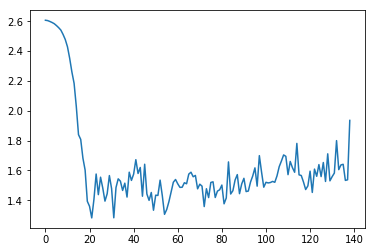

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(losses)

In [32]:
# plt.plot(losses[:200])

## the plan is to:
1. trian a binary classifier to judge if it is a silence audio or not
2. train a multi class classifier to predict the exact class if it is not silent
3. trian a multi-task classifier to do both thing metioned above

In [9]:
# get data from generator and pad within it
def audio_gen():
    for filename in all_training_file:
        y,sr = librosa.load(filename,sr=16000)
        if len(y)<16000:
            pad_with = (16000-len(y))//2+1
            y = np.pad(y,pad_with,'constant')[:16000]
        yield y
        
def silence_gen():
    for filename in all_silence_file:
        y,sr = librosa.load(filename,sr=16000)
        if len(y)<16000:
            pad_with = (16000-len(y))//2+1
            y = np.pad(y,pad_with,'constant')[:16000]
        yield y

data_a = tf.data.Dataset.from_generator(audio_gen,tf.float32)
data_s = tf.data.Dataset.from_generator(silence_gen,tf.float32)

In [10]:
label_bin_0 = tf.data.Dataset.from_tensor_slices([0]).repeat(len(all_training_file))
label_bin_1 = tf.data.Dataset.from_tensor_slices([1]).repeat(len(all_silence_file))
data_a = data_a.zip((data_a,label_bin_0)).shuffle(buffer_size=320).batch(32).repeat()
data_s = data_s.zip((data_s,label_bin_1)).shuffle(buffer_size=320).batch(32).repeat()

In [13]:
def get_sequence_from_file(filename):
    y,sr = librosa.load(filename,sr=16000)
    if load_audio:
        return y
    else:
        mel = librosa.feature.melspectrogram(y,sr,hop_length=256)
        db = librosa.power_to_db(mel, ref=np.min)
        return db

In [41]:
mapping_strings = tf.constant(list(class_indices.keys()))
table = tf.contrib.lookup.index_table_from_tensor(mapping=mapping_strings, num_oov_buckets=1, default_value=-1)
tf.tables_initializer().run()

In [62]:

# get data from tensorslice and pad with tensorflow method
# Tensorflow Sucks! 
def get_silent_data(filename):
    binary_label = tf.constant(0)
    data = tf.read_file(filename)
    audio_seq = tf.contrib.ffmpeg.decode_audio(data,file_format='wav',samples_per_second=16000,channel_count=1)
    # tensorflow does not support 1-d data padding mothod, make sure everything is 16000
    pad = tf.concat([audio_seq, tf.zeros((16000,1))],0)[:16000] 
    class_label=tf.constant(np.zeros(class_num,dtype=np.float32))
    return pad,binary_label,class_label

def get_label_from_filename(full_filename):
    label = (tf.string_split(full_filename,'/').values)[-1]
    label_indice = table.lookup(label)
    one_hot_encode = tf.one_hot(label_indice,len(class_indices))
    return one_hot_encode

def get_class_data(filename):
    binary_label = tf.constant(1)
    class_label=tf.constant(get_label_from_filename(filename))
    data = tf.read_file(filename)
    audio_seq = tf.contrib.ffmpeg.decode_audio(data,file_format='wav',samples_per_second=16000,channel_count=1)
    # tensorflow does not support 1-d data padding mothod, make sure everything is 16000
    pad = tf.concat([audio_seq, tf.zeros((16000,1))],0)[:16000] 
    class_label=tf.constant(get_label_from_filename(filename))
    return pad,binary_label,class_label

In [63]:
# data_s = binary_class_dataset_audio.map(get_silent_data).shuffle(buffer_size=320).batch(32)
data_a = binary_class_dataset_silence.map(get_class_data).shuffle(buffer_size=320).batch(32)

ValueError: Shape must be rank 1 but is rank 0 for 'StringSplit' (op: 'StringSplit') with input shapes: [], [].

In [121]:
# from tensorflow.python.keras.layers import Conv2D,MaxPool2D,BatchNormalization,Input,Activation,MaxPool1D,Reshape, Bidirectional,Flatten,Dense
# from tensorflow.python.keras.layers import GRU
# from tensorflow.python.keras.layers import LSTM
# from tensorflow.python.keras.models import Sequential

In [58]:
input_layer = Input((16000,1))
out = conv_1d_model(input_layer)
from keras import Model
model = Model(input_layer,out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 16000, 128)   65664       input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 16000, 128)   512         conv1d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_28 (MaxPooling1D) (None, 1599, 128)    0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
conv1d_25 

In [68]:
from keras import Sequential

# def buile_1d_conv_model(class_num):
#     model = Sequential()
#     model.add(Conv1D(128,512,padding='same', input_shape=(16000,1),activation='relu',dilation_rate=4))
#     model.add(BatchNormalization())
#     model.add(MaxPool1D(pool_size=(20),strides=10))
    
#     model.add(Conv1D(256,256,padding='same', activation='relu',dilation_rate=4))
#     model.add(BatchNormalization())
#     model.add(MaxPool1D(pool_size=(20),strides=10))
    
#     model.add(Bidirectional(LSTM(256,return_sequences=True),merge_mode='ave'))
#     model.add(Bidirectional(LSTM(256,return_sequences=True),merge_mode='ave'))
    
#     model.add(MaxPool1D(158))

#     model.add(Flatten())

#     return model

Using TensorFlow backend.


In [12]:
model = buile_1d_conv_model(1)
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',metrics=['binary_accuracy'],optimizer='sgd')

In [25]:
next_batch_all = [i.make_one_shot_iterator().get_next() for i in [data_a,data_s]]
next_seq_batch,next_label_batch = tf.concat([_[0] for _ in next_batch_all],0), tf.concat([_[1] for _ in next_batch_all],0)

In [16]:
sess = tf.InteractiveSession()

In [20]:
# for i in tqdm.tqdm_notebook(range(50)):
#     seq,label = sess.run([next_seq_batch,next_label_batch])
#     model.fit(np.expand_dims(seq,2),label,verbose=2)

Epoch 1/1
 - 4s - loss: 0.0365 - binary_accuracy: 0.9844
Epoch 1/1
 - 4s - loss: 0.0135 - binary_accuracy: 1.0000
Epoch 1/1
 - 4s - loss: 0.0678 - binary_accuracy: 0.9844
Epoch 1/1
 - 4s - loss: 0.0423 - binary_accuracy: 0.9844
Epoch 1/1
 - 4s - loss: 0.0652 - binary_accuracy: 0.9688
Epoch 1/1
 - 4s - loss: 0.0566 - binary_accuracy: 0.9844
Epoch 1/1
 - 4s - loss: 0.0322 - binary_accuracy: 1.0000
Epoch 1/1
 - 4s - loss: 0.0387 - binary_accuracy: 0.9844
Epoch 1/1
 - 4s - loss: 0.1268 - binary_accuracy: 0.9531
Epoch 1/1
 - 4s - loss: 0.0439 - binary_accuracy: 0.9844
Epoch 1/1
 - 4s - loss: 0.0638 - binary_accuracy: 0.9688
Epoch 1/1
 - 4s - loss: 0.0646 - binary_accuracy: 0.9844
Epoch 1/1
 - 4s - loss: 0.0475 - binary_accuracy: 0.9688
Epoch 1/1
 - 4s - loss: 0.0473 - binary_accuracy: 0.9844
Epoch 1/1
 - 4s - loss: 0.0210 - binary_accuracy: 1.0000
Epoch 1/1
 - 4s - loss: 0.0201 - binary_accuracy: 1.0000
Epoch 1/1
 - 4s - loss: 0.1242 - binary_accuracy: 0.9375
Epoch 1/1
 - 4s - loss: 0.0367 

In [26]:
seq,label = sess.run([next_seq_batch,next_label_batch])

In [29]:
label.shape

(64,)

In [ ]:
with open(os.path.join(data_root,"train/wrong.txt"),'r') as f:
    for line in sorted(f):
        file,pre = (line[:-1]).split()
        if file in s_list or file in w_list:
            continue
        label = file.split('/')[0]
        if label == 'silence':
            continue
        dst = os.path.join(data_root,"train/wrong/",label+'/')
        print(file)
        if not os.path.isdir(dst):
            os.mkdir(dst)
        shutil.copy(os.path.join(data_root,"train/audio/",file.replace("png",'wav')),dst)

In [11]:
def delete_wrong_label(list_of_files):
    for file in list_of_files:
        filename = file.replace("png",'wav')
        label = filename.split('/')[0]
        ori = os.path.join(data_root,"train/audio/",filename)
        if not os.path.isfile(ori):
            continue
        else:
            os.remove(ori)
def move_to_silence(list_of_files):
    for file in list_of_files:
        filename = file.replace("png",'wav')
        label = filename.split('/')[0]
        ori = os.path.join(data_root,"train/audio/",filename)
        if not os.path.isfile(ori):
            continue
        dst = os.path.join(data_root,"train/",filename.replace(label+"/","silence/"+label+"_"))
        print(dst)
        shutil.move(ori,dst)

In [12]:
move_to_silence(s_list)
delete_wrong_label(w_list)

/home/philip/Files/Keyword_spot/train/silence/on_7fd25f7c_nohash_3.wav
/home/philip/Files/Keyword_spot/train/silence/cat_1bc45db9_nohash_0.wav
/home/philip/Files/Keyword_spot/train/silence/bird_3e7124ba_nohash_0.wav
/home/philip/Files/Keyword_spot/train/silence/off_05b2db80_nohash_0.wav
/home/philip/Files/Keyword_spot/train/silence/nine_05b2db80_nohash_0.wav
/home/philip/Files/Keyword_spot/train/silence/house_5e3dde6b_nohash_0.wav
/home/philip/Files/Keyword_spot/train/silence/sheila_7c1d8533_nohash_0.wav
/home/philip/Files/Keyword_spot/train/silence/stop_7fd25f7c_nohash_1.wav
/home/philip/Files/Keyword_spot/train/silence/dog_29fb33da_nohash_0.wav
/home/philip/Files/Keyword_spot/train/silence/left_686d030b_nohash_1.wav
/home/philip/Files/Keyword_spot/train/silence/marvin_712e4d58_nohash_0.wav
/home/philip/Files/Keyword_spot/train/silence/nine_aff582a1_nohash_2.wav
/home/philip/Files/Keyword_spot/train/silence/wow_cc6ee39b_nohash_0.wav
/home/philip/Files/Keyword_spot/train/silence/stop_c

In [7]:
load_audio = True